In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from functools import partial
import jax
import jax.numpy as jnp
from jax import random
from jax import nn
from jax import vmap
from jax import grad

import tensorflow as tf
from jax.experimental import jax2tf
import tf2onnx
import onnx
import onnxruntime as ort

In [6]:
data_df = pd.read_csv('./data/train.csv')

In [7]:
np.random.shuffle(data_df.values)
m, n = data_df.shape
Y = jnp.array(data_df["label"])
data_df = data_df.drop("label", axis=1)
X = jnp.array(data_df)

X_train = X[1000:]
X_train = X_train / 255.
Y_train = Y[1000:]

X_val = X[:1000]
X_val = X_val / 255.
Y_val = Y[:1000]

In [8]:
@jax.jit
def init_params():
    key = random.PRNGKey(42)
    key, *subkey = random.split(key, 5)
    W1 = random.uniform(subkey[0], (10, 784), jnp.float32, -0.5, 0.5)
    b1 = random.uniform(subkey[1], (10,), jnp.float32, -0.5, 0.5)
    W2 = random.uniform(subkey[2], (10, 10), jnp.float32, -0.5, 0.5)
    b2 = random.uniform(subkey[3], (10,), jnp.float32, -0.5, 0.5)
    return W1, b1, W2, b2

@jax.jit
def ReLU(Z):
    return jnp.maximum(Z, 0)

@jax.jit
def softmax(Z):
    A = jnp.exp(Z) / sum(jnp.exp(Z))
    return A   

@jax.jit
def forward(W1, b1, W2, b2, x):
    # single example forward pass
    z1 = W1.dot(x) + b1
    a1 = ReLU(z1)
    z2 = W2.dot(a1) + b2
    a2 = softmax(z2)
    return a2

batched_forward = jax.jit(vmap(forward, in_axes=(None, None, None, None, 0)))

In [9]:
@partial(jax.jit, static_argnames=['k'])
def one_hot(x, k, dtype=jnp.float32):
    """Create a one-hot encoding of x of size k."""
    return jnp.array(x[:, None] == jnp.arange(k), dtype)

@jax.jit
def loss_fn(W1, b1, W2, b2, X, Y):
    A2 = batched_forward(W1, b1, W2, b2, X)
    one_hot_Y = one_hot(Y, 10)
    loss = -jnp.sum(one_hot_Y * jnp.log(A2)) / m
    return loss

@jax.jit
def update_params(W1, b1, W2, b2, alpha, X, Y):
    dW1, db1, dW2, db2 = grad(loss_fn, argnums=(0, 1, 2, 3))(W1, b1, W2, b2, X, Y)
    W1 = W1 - alpha * dW1
    b1 = b1 - alpha * db1    
    W2 = W2 - alpha * dW2  
    b2 = b2 - alpha * db2    
    return W1, b1, W2, b2

In [10]:
@jax.jit
def get_predictions(A2):
    return jnp.argmax(A2, axis=1)

@jax.jit
def get_accuracy(predictions, Y):
    return jnp.mean(predictions == Y)

def gradient_descent(X, Y, alpha, iterations):
    W1, b1, W2, b2 = init_params()
    for i in range(iterations):
        W1, b1, W2, b2 = update_params(W1, b1, W2, b2, alpha, X, Y)
        if i % 10 == 0:
            print("Iteration: ", i)
            A2 = batched_forward(W1, b1, W2, b2, X)
            predictions = get_predictions(A2)
            print(get_accuracy(predictions, Y))
    return W1, b1, W2, b2

In [11]:
W1, b1, W2, b2 = gradient_descent(X_train, Y_train, 0.10, 500)

Iteration:  0
0.122999996
Iteration:  10
0.25331706
Iteration:  20
0.34092683
Iteration:  30
0.39704877
Iteration:  40
0.44958535
Iteration:  50
0.5013171
Iteration:  60
0.5449512
Iteration:  70
0.58256096
Iteration:  80
0.608878
Iteration:  90
0.6311951
Iteration:  100
0.65114635
Iteration:  110
0.66809756
Iteration:  120
0.68204874
Iteration:  130
0.69485366
Iteration:  140
0.7044634
Iteration:  150
0.7154634
Iteration:  160
0.7247073
Iteration:  170
0.7327561
Iteration:  180
0.74039024
Iteration:  190
0.746878
Iteration:  200
0.7533658
Iteration:  210
0.7594878
Iteration:  220
0.765439
Iteration:  230
0.7714634
Iteration:  240
0.77675605
Iteration:  250
0.7815366
Iteration:  260
0.7854878
Iteration:  270
0.7893171
Iteration:  280
0.79385364
Iteration:  290
0.7974878
Iteration:  300
0.80146337
Iteration:  310
0.80441463
Iteration:  320
0.80768293
Iteration:  330
0.81060976
Iteration:  340
0.81324387
Iteration:  350
0.8153902
Iteration:  360
0.81799996
Iteration:  370
0.8206829
Iterat

In [12]:

def make_predictions(X, W1, b1, W2, b2):
    A2 = batched_forward(W1, b1, W2, b2, X)
    predictions = get_predictions(A2)
    return predictions

def test_prediction(index, W1, b1, W2, b2):
    current_image = X_train[None, index]
    prediction = make_predictions(X_train[None, index], W1, b1, W2, b2)
    label = Y_train[index]
    print("Prediction: ", prediction)
    print("Label: ", label)
    
    current_image = current_image.reshape((28, 28)) * 255
    plt.gray()
    plt.imshow(current_image, interpolation='nearest')
    plt.show()

Prediction:  [5]
Label:  5


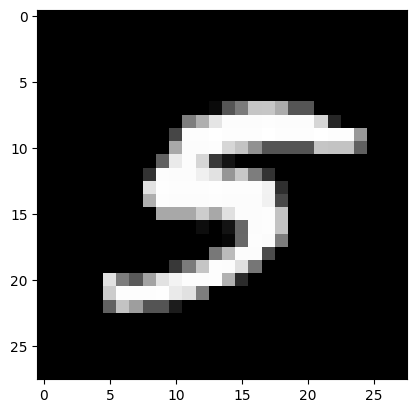

Prediction:  [4]
Label:  4


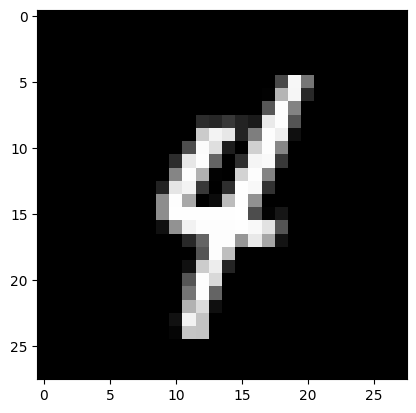

Prediction:  [7]
Label:  7


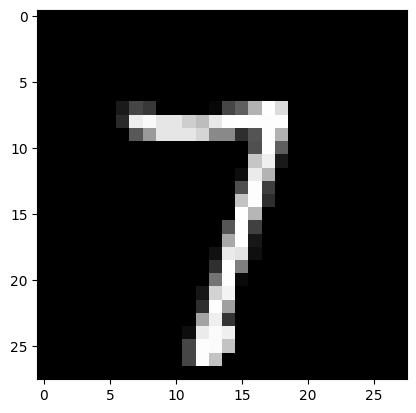

Prediction:  [2]
Label:  2


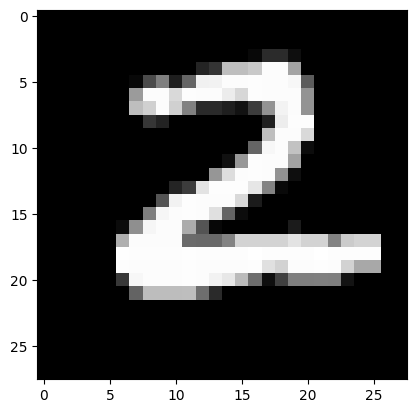

In [13]:
test_prediction(0, W1, b1, W2, b2)
test_prediction(1, W1, b1, W2, b2)
test_prediction(2, W1, b1, W2, b2)
test_prediction(3, W1, b1, W2, b2)

In [14]:
val_predictions = make_predictions(X_val, W1, b1, W2, b2)
get_accuracy(val_predictions, Y_val)

DeviceArray(0.83300006, dtype=float32)

In [15]:
# NOTE: We need enable_xla=False because tf2onnx is not aware of some XLA
#       specific TF ops (e.g. DotGeneral).
forward_tf = tf.function(jax2tf.convert(batched_forward, enable_xla=False))

In [18]:
forward_tf(W1, b1, W2, b2, jnp.array(X_train[None, 0]))

2022-09-05 17:33:50.234722: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 30.6KiB (rounded to 31488)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-09-05 17:33:50.234843: W tensorflow/core/common_runtime/bfc_allocator.cc:491] <allocator contains no memory>


InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

In [19]:
X_train[None, 0].shape

(1, 784)

In [20]:
X_train[None, 0].dtype

dtype('float32')

In [23]:
input_signature = (tf.TensorSpec(X_train[None, 0].shape, X_train[None, 0].dtype),)
input_signature

(TensorSpec(shape=(1, 784), dtype=tf.float32, name=None),)

In [24]:
model_proto, external_tensor_storage = tf2onnx.convert.from_function(forward_tf, input_signature)

ValueError: in user code:

    File "/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/jax/experimental/jax2tf/jax2tf.py", line 302, in fun_no_kwargs  *
        return fun(*args, **kwargs)
    File "/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/jax/experimental/jax2tf/jax2tf.py", line 534, in _interpret_fun  *
        out_vals: Sequence[Tuple[TfVal, core.ShapedArray]] =               _call_wrapped_with_new_constant_cache(fun, in_vals,
    File "/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/jax/experimental/jax2tf/jax2tf.py", line 688, in _call_wrapped_with_new_constant_cache  *
        out_vals: Sequence[Tuple[TfVal, core.ShapedArray]] =         fun.call_wrapped(*in_vals)
    File "/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/jax/linear_util.py", line 168, in call_wrapped  *
        ans = self.f(*args, **dict(self.params, **kwargs))
    File "/tmp/__autograph_generated_filer183yq3s.py", line 43, in fun_no_kwargs  **
        retval__1 = ag__.converted_call(ag__.ld(fun), tuple(ag__.ld(args)), dict(**ag__.ld(kwargs)), fscope_1)
    File "/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/jax/_src/traceback_util.py", line 162, in reraise_with_filtered_traceback  **
        return fun(*args, **kwargs)
    File "/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/jax/_src/api.py", line 527, in cache_miss
        out_flat = xla.xla_call(
    File "/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/jax/core.py", line 1937, in bind
        return call_bind(self, fun, *args, **params)
    File "/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/jax/core.py", line 1953, in call_bind
        outs = top_trace.process_call(primitive, fun_, tracers, params)
    File "/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/jax/experimental/jax2tf/jax2tf.py", line 1066, in process_call
        vals_out = interpreted_fun.call_wrapped(*vals)
    File "/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/jax/linear_util.py", line 168, in call_wrapped
        ans = self.f(*args, **dict(self.params, **kwargs))
    File "/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/jax/_src/traceback_util.py", line 162, in reraise_with_filtered_traceback
        return fun(*args, **kwargs)
    File "/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/jax/_src/api.py", line 1562, in vmap_f
        in_axes_flat = flatten_axes("vmap in_axes", in_tree, (in_axes, 0), kws=True)
    File "/home/ubuntu20/anaconda3/envs/jax0.3/lib/python3.10/site-packages/jax/_src/api_util.py", line 416, in flatten_axes
        raise ValueError(f"{name} specification must be a tree prefix of the "

    ValueError: vmap in_axes specification must be a tree prefix of the corresponding value, got specification (None, None, None, None, 0) for value tree PyTreeDef((*,)).
